# 5章 回帰不連続デザイン（RDD）

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd

import rdata
from rdd import rdd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from propensity_score_matching import PropensityScoreMatching

## 5.2 回帰不連続デザイン（RDD）

### 5.2.3 メールによる来訪率の増加効果を分析する

In [2]:
email_data = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
email_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
male_data = email_data[email_data['segment'] != 'Womens E-Mail']
male_data['treatment'] = male_data['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_data['history_log'] = np.log(male_data['history'])
male_data['history_log_grp'] = np.round(male_data['history_log']/0.1)*0.1
male_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301,5.8
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942,6.5
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816,6.5
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,4.621437,4.6
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538,5.5


In [4]:
male_data_groupby = male_data.groupby(['history_log_grp', 'segment'])['visit'].agg(['mean', 'count']).reset_index()
male_data_groupby = male_data_groupby.loc[male_data_groupby['count'] > 10]
male_data_groupby.head()

,history_log_grp,segment,mean,count
0,3.4,Mens E-Mail,0.146545,2750
1,3.4,No E-Mail,0.086988,2805
2,3.5,Mens E-Mail,0.169118,272
3,3.5,No E-Mail,0.084942,259
4,3.6,Mens E-Mail,0.158576,309


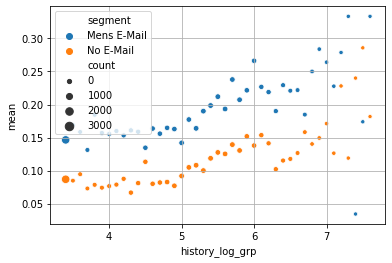

In [5]:
sns.scatterplot(
    data=male_data_groupby,
    x='history_log_grp',
    y='mean',
    hue='segment',
    size='count'
)

plt.grid()

In [6]:
threshold_value = 5.5

rdd_data = male_data.loc[
    ((male_data['history_log'] > threshold_value) & (male_data['segment'] == 'Mens E-Mail')) |
    ((male_data['history_log'] <= threshold_value) & (male_data['segment'] == 'No E-Mail'))
]

In [7]:
rdd_data_groupby = rdd_data.groupby(['history_log_grp', 'segment'])['visit'].agg(['mean', 'count']).reset_index()
rdd_data_groupby = rdd_data_groupby.loc[rdd_data_groupby['count'] > 10]
rdd_data_groupby.head()

,history_log_grp,segment,mean,count
0,3.4,No E-Mail,0.086988,2805
1,3.5,No E-Mail,0.084942,259
2,3.6,No E-Mail,0.094637,317
3,3.7,No E-Mail,0.073090,301
4,3.8,No E-Mail,0.078652,356


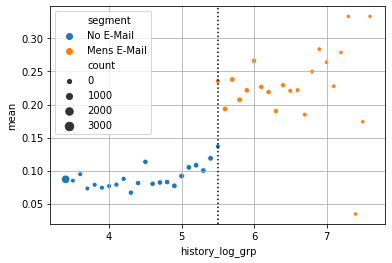

In [8]:
sns.scatterplot(
    data=rdd_data_groupby,
    x='history_log_grp',
    y='mean',
    hue='segment',
    size='count'
)

plt.grid()
plt.axvline([5.5], color='black', ls=':')

In [9]:
# 集計による比較
rdd_data.groupby(['treatment'])['visit'].agg(['mean', 'count'])

,mean,count
treatment,,
0,0.090694,13926
1,0.224002,7366


In [10]:
# 線形回帰による分析
rdd_lm_reg = smf.ols(
    data=rdd_data,
    formula='visit ~ treatment + history_log'
).fit()

rdd_lm_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0404,0.016,2.454,0.014,0.008,0.073
treatment,0.1137,0.008,14.240,0.000,0.098,0.129
history_log,0.0114,0.004,3.103,0.002,0.004,0.019


In [11]:
# 非線形回帰による分析
for i in range(4):
    poly_col_name = 'history_log' + '_' + str(i+1)
    interaction_col_name = 'treatment_' + 'history_log' + '_' + str(i+1)
    rdd_data[poly_col_name] = (rdd_data['history_log']-threshold_value)**(i+1)
    rdd_data[interaction_col_name] = rdd_data[poly_col_name] * rdd_data['treatment']

In [12]:
nonlinear_rdd_ord4 = smf.ols(
    data=rdd_data,
    formula='''
        visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 + 
                treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4
    '''
).fit()

nonlinear_rdd_ord4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1327,0.014,9.654,0.000,0.106,0.160
treatment,0.0741,0.020,3.774,0.000,0.036,0.113
history_log_1,0.1522,0.092,1.661,0.097,-0.027,0.332
history_log_2,0.1877,0.178,1.056,0.291,-0.161,0.536
history_log_3,0.1068,0.126,0.847,0.397,-0.140,0.354
history_log_4,0.0224,0.029,0.769,0.442,-0.035,0.079
treatment_history_log_1,-0.0406,0.135,-0.300,0.764,-0.306,0.225
treatment_history_log_2,-0.3928,0.271,-1.449,0.147,-0.924,0.139
treatment_history_log_3,0.0278,0.198,0.140,0.888,-0.360,0.415
treatment_history_log_4,-0.0484,0.047,-1.032,0.302,-0.140,0.044


## 5.3 nonparametric RDD

In [13]:
# 利用するデータの範囲と推定結果のプロット
bound_list = [i/100 for i in range(2, 101)]
result_data = pd.DataFrame()
for i, bound in enumerate(bound_list):
    out_data = rdd_data[rdd_data['history_log'].between(5.5-bound, 5.5+bound)]
    out_data_groupby = out_data.groupby('treatment')['visit'].describe()
    late = out_data_groupby['mean'].values[1] - out_data_groupby['mean'].values[0]
    n = sum(out_data_groupby['count'])
    se = np.sqrt(sum(out_data_groupby['mean']**2))/np.sqrt(n)
    result_data = pd.concat([result_data, pd.DataFrame({'late': late, 'bound': bound, 'n': n, 'se': se}, index=[i])])

In [14]:
result_data['lower_interval'] = result_data['late'] - result_data['se']*1.96
result_data['upper_interval'] = result_data['late'] + result_data['se']*1.96

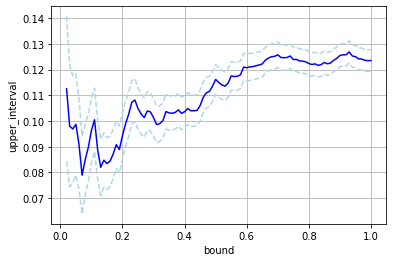

In [15]:
ax = sns.lineplot(data=result_data, x='bound', y='late', color='blue')
ax = sns.lineplot(data=result_data, x='bound', y='lower_interval', color='lightblue')
ax = sns.lineplot(data=result_data, x='bound', y='upper_interval', color='lightblue')

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.grid()

### 5.3.2 nonparametric RDDの実装

In [16]:
bandwidth_opt = rdd.optimal_bandwidth(rdd_data['visit'], rdd_data['history_log'], cut=threshold_value)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 0.6942601178278147


In [17]:
data_rdd = rdd.truncated_data(rdd_data, 'history_log', bandwidth_opt, cut=threshold_value)

In [18]:
rdd_result = smf.ols(
    data=data_rdd,
    formula='''visit ~ treatment + history_log_1 + history_log_2 + history_log_3 + history_log_4 + 
                treatment_history_log_1 + treatment_history_log_2 + treatment_history_log_3 + treatment_history_log_4'''
).fit()

rdd_result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1385,0.026,5.335,0.000,0.088,0.189
treatment,0.0765,0.037,2.092,0.036,0.005,0.148
history_log_1,0.3670,0.514,0.714,0.475,-0.641,1.375
history_log_2,1.6993,3.002,0.566,0.571,-4.185,7.583
history_log_3,3.4643,6.490,0.534,0.594,-9.258,16.186
history_log_4,2.2943,4.638,0.495,0.621,-6.797,11.386
treatment_history_log_1,-0.3851,0.735,-0.524,0.600,-1.826,1.055
treatment_history_log_2,-1.7551,4.319,-0.406,0.684,-10.221,6.711
treatment_history_log_3,-2.5272,9.377,-0.270,0.788,-20.908,15.853
treatment_history_log_4,-3.3742,6.721,-0.502,0.616,-16.548,9.799
